In [1]:
import os
os.getcwd()

'c:\\Desktop\\AgenticSQL\\code'

In [2]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [3]:
## download chinook database

## it is a small database with tables related to music, albums, track etc. so we can use it with sqlite.

import requests

url = "https://github.com/tharani001/MyDatasets/raw/refs/heads/main/db_samples/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("../database/Chinook.db", "wb") as file:
        file.write(response.content)
    print("Chinook.db downloaded successfully.")
else:
    print(f"Failed to download Chinook.db. Status code: {response.status_code}")

Chinook.db downloaded successfully.


### Load Database with Langchain SQLDatabase

In [6]:
# sqlite is small database that provides similar functionality to mysql and postgresql.

from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///../database/Chinook.db")
# print(db.table_names())
print(db.dialect)
print(db.get_table_info()) 

sqlite

CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCE

In [8]:
print(db.run("SELECT * FROM Album LIMIT 5;"))

[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2), (3, 'Restless and Wild', 2), (4, 'Let There Be Rock', 1), (5, 'Big Ones', 3)]


### LLM initialization

In [9]:
# Qwen2.5 is twice the size of LLAMA3.2 model but it performs better on code related tasks.

from langchain_ollama import ChatOllama

model = "qwen2.5:7b"

base_url = "http://localhost:11434"

llm  = ChatOllama(model=model, base_url=base_url)

llm

ChatOllama(model='qwen2.5:7b', base_url='http://localhost:11434')

### Building Graph State 

In [10]:
# Graph is workflow that controls the how an agent thinks and acts by managing the flow of states between the nodes.

# state is just a dictionary that contains the messages.

# each node takes a state and returns a new state. it gets updated with the new state.

from typing import TypedDict

class State(TypedDict):
    question : str
    query : str
    result : str
    answer : str

### SQL Query prompt from Langchain hub

In [11]:
from langchain import hub

query_prompt_template = hub.pull('langchain-ai/sql-query-system-prompt')

query_prompt_template

ChatPromptTemplate(input_variables=['dialect', 'input', 'table_info', 'top_k'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'sql-query-system-prompt', 'lc_hub_commit_hash': '360a0e9d0f0f5da0ee9810a2a0ea3c9dc3de31b3ae9d50272420c33e48e6e323'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'table_info', 'top_k'], input_types={}, partial_variables={}, template='Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema

In [15]:
query_prompt_template.input_variables, query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


(['dialect', 'input', 'table_info', 'top_k'], None)

### Output Parser

In [16]:
from typing import Annotated

class QueryOutput(TypedDict):
    """Generated SQL query"""

    query: Annotated[str, ..., "Syntactically correct and valid SQL query"]

QueryOutput({"query": "SELECT * FROM album LIMIT 2"})
QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'Syntactically correct and valid SQL query']}

In [20]:
llm.with_structured_output(QueryOutput)

RunnableBinding(bound=ChatOllama(model='qwen2.5:7b', base_url='http://localhost:11434'), kwargs={'format': {'title': 'QueryOutput', 'description': 'Generated SQL query', 'type': 'object', 'properties': {'query': {'description': 'Syntactically correct and valid SQL query', 'type': 'string'}}, 'required': ['query']}, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema'}, 'schema': {'title': 'QueryOutput', 'description': 'Generated SQL query', 'type': 'object', 'properties': {'query': {'description': 'Syntactically correct and valid SQL query', 'type': 'string'}}, 'required': ['query']}}}, config={}, config_factories=[])
| JsonOutputParser()

### Write node: It turns question to a SQL Query

In [25]:
def write_query(state: State) -> State:
    """Generate MySQL query to fetch information"""

    prompt = query_prompt_template.invoke({
        "dialect": db.dialect,
        "top_k": 5,
        "table_info": db.get_table_info(),
        "input": state["question"]
    })
     
    output_parse_llm = llm.with_structured_output(QueryOutput)

    result = output_parse_llm.invoke(prompt)

    return {"query" : result["query"]}



In [26]:
write_query({"question": " How many albums are there in the database?"})

{'query': 'select count(*) from album'}

### Execute Query Node:  It generates the result

In [27]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query(state:State):
    """Execute SQL query and return the result"""
    query = state["query"]
    execute_query_tool = QuerySQLDataBaseTool(db=db)

    return {'result': execute_query_tool.invoke({"query": query})}

In [28]:
execute_query({"query": "SELECT * FROM album LIMIT 2"})

C:\Users\thara\AppData\Local\Temp\ipykernel_24432\4185605201.py:6: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query_tool = QuerySQLDataBaseTool(db=db)


{'result': "[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2)]"}

### Generate Answer Node: It turns the result into a response for the question

In [29]:
def generate_answer(state:State):
    """Generate answer using retrieved information as the context""" 

    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )

    response = llm.invoke(prompt)

    return {"answer": response.content}

### Node Testing

In [30]:
question =  "How many albums are there in the database?"
query = write_query({"question": question})
query

{'query': 'SELECT COUNT(*) FROM album'}

In [31]:
result = execute_query(query)
result

{'result': '[(347,)]'}

In [32]:
state = {"question": question, **query, **result}
state

{'question': 'How many albums are there in the database?',
 'query': 'SELECT COUNT(*) FROM album',
 'result': '[(347,)]'}

In [33]:
generate_answer(state)

{'answer': 'Based on the provided SQL query and result, there are 347 albums in the database. The SQL query `SELECT COUNT(*) FROM album` counts all the rows in the `album` table, which corresponds to the number of albums. The result `(347,)` indicates that there are 347 entries in the `album` table.'}

### Building Workflow with graph connecting all the nodes

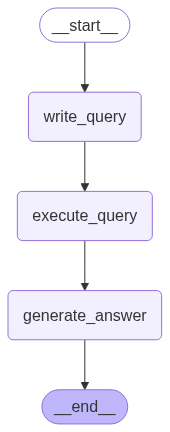

In [35]:
from langgraph.graph import StateGraph, START
### Add memory to the chatbot

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() # memory saver to store the state of the graph


workflow = StateGraph(State)

# Add nodes to the workflow
workflow.add_node("write_query", write_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("generate_answer", generate_answer)

# add edges to the workflow
workflow.add_edge(START, "write_query")
workflow.add_edge("write_query", "execute_query")
workflow.add_edge("execute_query", "generate_answer")

graph = workflow.compile(checkpointer=memory) # checkpointer is used for memory)

graph

### Testing the graph

In [ ]:
config = {'configurable':{'thread_id':101}}
graph.invoke({"question": 'How many albums are there in the database?'},config=config)

{'question': 'How many albums are there in the database?',
 'query': 'SELECT COUNT(*) FROM album',
 'result': '[(347,)]',
 'answer': 'Based on the SQL result provided, there are 347 albums in the database. The result `(347,)` indicates that the count of rows in the `album` table is 347.'}

In [42]:
for step in graph.stream({'question':'List down the composers in Track table?'}, stream_mode="updates",config=config):
    print(step)

{'write_query': {'query': 'SELECT Composer FROM Track'}}
{'execute_query': {'result': '[(\'Angus Young, Malcolm Young, Brian Johnson\',), (None,), (\'F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman\',), (\'F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman\',), (\'Deaffy & R.A. Smith-Diesel\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'Angus Young, Malcolm Young, Brian Johnson\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'AC/DC\',), (\'Steven Tyler, Joe Perry, Jack Blades, Tommy Shaw\',), (\'Steven Tyler, Joe Perry\',), (\'Steven Tyler, Joe Perry, 

##### This graph workflow works well for simple tasks. it can be deceitful when you ask complex questions.

### Building Agent with LangchainSQL Tools and LLM

In [43]:
from langchain import hub

prompt = hub.pull("langchain-ai/sql-agent-system-prompt")

In [44]:
prompt.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [45]:
system_prompt = prompt.invoke({'dialect': db.dialect, 'top_k': 5})
system_prompt = prompt.format(dialect = db.dialect, top_k = 5)

In [46]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [47]:
toolkit.get_context()

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

In [48]:
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001DA1A044F10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001DA1A044F10>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001DA1A044F10>),
 QuerySQLCheckerTool(description='Use this tool to 

In [49]:
tools[0].invoke("select * from Album LIMIT 2")

"[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2)]"

In [50]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

In [51]:
agent_executor = create_react_agent(llm, tools, prompt=system_prompt)

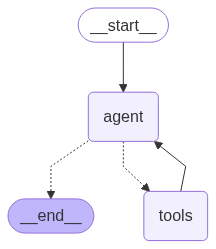

In [52]:
agent_executor

In [53]:
question = "Which country's customers have made the most purchases?"
query = {"messages": [HumanMessage(question)]}

for step in agent_executor.stream(query, stream_mode="updates"):
    print(step)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-06-11T08:37:54.2714426Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5773790700, 'load_duration': 77161700, 'prompt_eval_count': 717, 'prompt_eval_duration': 1501000000, 'eval_count': 37, 'eval_duration': 4169000000, 'model_name': 'qwen2.5:7b'}, id='run--e977cdee-6675-40b3-b686-7c9534d018a5-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '7948a98a-c388-45d3-8090-d9878cc4c3a2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 717, 'output_tokens': 37, 'total_tokens': 754})]}}
{'tools': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='b24bbac1-83ce-410c-89e3-40e2c7636d6c', tool_call_id='7948a98a-c388-45d3-8090-d9878cc4c3a2')]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response